In [1]:
run_gridsearch = False
skip_best_model_validation = True
skip_best_model_test = True
verbose = False
GPU_SETTING = -1
NUM_ENSEMBLES = 5
BASIN = "hopland"
MODE = "daily"
RUN_LABEL = "BASELINE"
READ_STAMP = "20250815T000000Z"

In [2]:
hyperparam_space = {
    "hidden_size": [64, 128, 256],
    "output_dropout": [0.4],
    "seq_length": [90, 120],
    "num_layers": [1],
    "epochs": [16, 32, 48],
    "batch_size": [64, 128, 256],
    "schedule_pairs": [
        ((0.5, 0.25), (0.01, 0.005, 0.001))
    ]
}

In [3]:
import sys
import pandas as pd
import os
import itertools
from pathlib import Path
from tqdm import tqdm
import warnings
from datetime import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
current_dir = os.getcwd()
print(current_dir)

/Users/canruso/Desktop/UCB-USACE-LSTMs/notebooks/basins/hopland


In [5]:
library_path = os.path.join('..', '..', '..','..','UCB-USACE-RR-PROJECT')
sys.path.insert(0, library_path)
print(sys.path)

['../../../../UCB-USACE-LSTMs', '/Users/canruso/Desktop/UCB-USACE-LSTMs/notebooks/basins/hopland', '/Users/canruso/Desktop', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python310.zip', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/lib-dynload', '', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/setuptools/_vendor']


In [6]:
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import (fractional_multi_lr, write_paths, to_path_or_list, ensure_output_tree, set_active_context, data_dir, repo_root, get_output_dir, make_run_stamp, get_yaml_path, ctx_for, hparams_exists, save_hparams, load_hparams, runs_latest_path, archive_runs_json, read_csv_artifact, ensure_shared_tree)
from UCB_training.UCB_plotting import (plot_timeseries_comparison, scatter_triptych_pngs_v3, ts_triptych_v3)

In [7]:
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-RR-PROJECT')[0] + 'UCB-USACE-RR-PROJECT'

In [8]:
RUNS_FILE = str(runs_latest_path(BASIN, MODE, RUN_LABEL))
SHOULD_STAMP = not (skip_best_model_validation and skip_best_model_test)
RUN_STAMP = make_run_stamp() if SHOULD_STAMP else None
ACTIVE_STAMP = RUN_STAMP if RUN_STAMP is not None else READ_STAMP

In [9]:
set_active_context(basin=BASIN, resolution=MODE, run_stamp=ACTIVE_STAMP, run_tag=RUN_LABEL, append_stamp_to_filenames=False)
SHARED_FOLDER = ensure_shared_tree(BASIN, MODE)
RUNS_PARENT = SHARED_FOLDER / "runs" / (f"{RUN_LABEL}_{RUN_STAMP}" if RUN_STAMP else RUN_LABEL)

print("NH runs will be written under:")
print(RUNS_PARENT.resolve())

NH runs will be written under:
/Users/canruso/Desktop/UCB-USACE-LSTMs/outputs/hopland/daily_shared/runs/BASELINE


In [10]:
path_to_csv = data_dir()
path_to_yaml = get_yaml_path("hopland_gage_nlayers")
path_to_physics_data = path_to_csv / "Hopland_daily_shift.csv"

In [11]:
features_with_physics = [
    #from daily.csv
    "RUSSIAN 60 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 60 PRECIP-INC SCREENED",
    "RUSSIAN 70 PRECIP-INC SCREENED",
    "RUSSIAN 70 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "WF RUSSIAN PRECIP-INC SCREENED",
    "WF RUSSIAN ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    #from hopland.csv
    'Hopland Gage FLOW',
    'Russian 60 ET-POTENTIAL',
    'Russian 60 FLOW',
    'Russian 60 FLOW-BASE',
    'Russian 60 INFILTRATION',
    'Russian 60 PERC-SOIL',
    'Russian 60 SATURATION FRACTION',
    'Russian 70 ET-POTENTIAL',
    'Russian 70 FLOW',
    'Russian 70 FLOW-BASE',
    'Russian 70 INFILTRATION',
    'Russian 70 PERC-SOIL',
    'Russian 70 SATURATION FRACTION',
    'WF Russian ET-POTENTIAL',
    'WF Russian FLOW',
    'WF Russian FLOW-BASE',
    'WF Russian INFILTRATION',
    'WF Russian PERC-SOIL',
    'WF Russian SATURATION FRACTION',
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    "UKIAH CA FLOW USGS-MERGED",
    #"Lake Mendocino Storage",    
]

In [12]:
no_physics_results = []
physics_results = []

In [13]:
start_time = datetime.utcnow()
print("Start time:", start_time.strftime("%Y-%m-%d %H:%M:%S"))

Start time: 2025-08-26 14:20:05


In [14]:
hyperparam_names = []
for i, hp in enumerate(hyperparam_space.keys()):
    hyperparam_names.append(hp)

total_iters = 1
for name in hyperparam_names:
    total_iters *= len(hyperparam_space[name])

if run_gridsearch or not hparams_exists(BASIN, MODE, RUN_LABEL):
    for combinations in tqdm(
        itertools.product(*[hyperparam_space[hp] for hp in hyperparam_names]), 
        desc="Grid-Search", 
        total=total_iters, 
        unit="it", 
        ncols=60, 
        ascii=True):

        hp_run = {}
        j = 0
        schedule_pairs = None
        
        while j < len(hyperparam_names):
            name = hyperparam_names[j]
            val = combinations[j]

            if name == "seq_length":
                hp_run["seq_length"] = val

            elif name == "schedule_pairs":
                schedule_pairs = val

            else:
                hp_run[name] = val

            j += 1

        if schedule_pairs is not None:
            fractions, rates = schedule_pairs
            hp_run["learning_rate"] = fractional_multi_lr(
                epochs=int(hp_run["epochs"]), fractions=list(fractions), lrs=list(rates))
        else:
            hp_run.setdefault("learning_rate", {0: 0.01, 30: 0.005, 40: 0.001})

        if verbose:
            print(f"\nNoPhysics: {hp_run}")
            
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp_run,
            input_features=None,
            physics_informed=False,
            physics_data_file=None,
            hourly=False,  
            extend_train_period=False,
            gpu=GPU_SETTING,
            verbose=verbose,
            runs_parent=RUNS_PARENT,
            run_label=RUN_LABEL,
            run_stamp=RUN_STAMP)
        
        trainer.train()
        csv_path, metrics_dict = trainer.results()
        
        row_data = {}
        j = 0
        while j < len(hyperparam_names):
            row_data[hyperparam_names[j]] = combinations[j]
            j += 1
            
        row_data["learning_rate"] = str(hp_run["learning_rate"])
        
        for k, v in metrics_dict.items():
            row_data[k] = v
        
        no_physics_results.append(row_data)

    df_no_physics = pd.DataFrame(no_physics_results)
    df_no_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_no_physics.reset_index(drop=True, inplace=True)
else:
    print("Skipping grid search!")

Skipping grid search!


In [15]:
if run_gridsearch or not hparams_exists(BASIN, MODE, RUN_LABEL):  
    for combinations in tqdm(
        itertools.product(*[hyperparam_space[hp] for hp in hyperparam_names]), 
        desc="Grid-Search", 
        total=total_iters, 
        unit="it", 
        ncols=60, 
        ascii=True):

        hp_run = {}
        j = 0
        schedule_pairs = None

        while j < len(hyperparam_names):
            name = hyperparam_names[j]
            val  = combinations[j]

            if name == "seq_length":
                hp_run["seq_length"] = val

            elif name == "schedule_pairs":
                schedule_pairs = val

            else:
                hp_run[name] = val

            j += 1

        if schedule_pairs is not None:
            fractions, rates = schedule_pairs
            hp_run["learning_rate"] = fractional_multi_lr(
                epochs=int(hp_run["epochs"]), fractions=list(fractions), lrs=list(rates))
        else:
            hp_run.setdefault("learning_rate", {0: 0.01, 30: 0.005, 40: 0.001})
            
        if verbose:
            print(f"\nPhysics: {hp_run}")
            
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp_run,
            input_features=features_with_physics,
            physics_informed=True,
            physics_data_file=path_to_physics_data,
            hourly=False,
            extend_train_period=False,
            gpu=GPU_SETTING,
            verbose=verbose,
            runs_parent=RUNS_PARENT,
            run_label=RUN_LABEL,
            run_stamp=RUN_STAMP)
        
        trainer.train()
        csv_path, metrics_dict = trainer.results()

        row_data = {}
        j = 0
        while j < len(hyperparam_names):
            row_data[hyperparam_names[j]] = combinations[j]
            j += 1
            
        row_data["learning_rate"] = str(hp_run["learning_rate"])

        for k, v in metrics_dict.items():
            row_data[k] = v
            
        physics_results.append(row_data)
    df_physics = pd.DataFrame(physics_results)
    df_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_physics.reset_index(drop=True, inplace=True)
    best_no_phys = df_no_physics.iloc[0].to_dict()
    best_phys = df_physics.iloc[0].to_dict()
    best_no_phys["model_type"] = "no_physics"
    best_phys["model_type"] = "physics"
    best_params_df = pd.DataFrame([best_no_phys, best_phys])
    save_hparams(best_df=best_params_df, basin=BASIN, mode=MODE, label=RUN_LABEL, run_stamp=RUN_STAMP, df_no=df_no_physics, df_phys=df_physics)
else:
    print("Skipping grid search!")

Skipping grid search!


In [16]:
try:
    if run_gridsearch:
        print("\n[INFO] Using best_params_df from the just-completed grid search (ignoring READ_STAMP).")
    else:
        print("\nLoading best hyperparams from CSV...")
        best_params_df = load_hparams(BASIN, MODE, RUN_LABEL, stamp=READ_STAMP)
except FileNotFoundError as e:
    raise SystemExit(f"[ERROR] {e}  (Set run_gridsearch=True to generate it.)")

best_no_phys = best_params_df.query("model_type == 'no_physics'").iloc[0].to_dict()
best_phys = best_params_df.query("model_type == 'physics'").iloc[0].to_dict()

best_no_physics_params = {}
j = 0
while j < len(hyperparam_names):
    name = hyperparam_names[j]
    if name == "output_dropout":
        best_no_physics_params[name] = float(best_no_phys[name])
        j += 1

    elif name == "seq_length":
        best_no_physics_params["seq_length"] = int(best_no_phys["seq_length"])
        j += 1

    elif name == "schedule_pairs":
        j += 1

    else:
        best_no_physics_params[name] = int(best_no_phys[name])
        j += 1

if "learning_rate" in best_no_phys and pd.notna(best_no_phys["learning_rate"]):
    best_no_physics_params["learning_rate"] = eval(str(best_no_phys["learning_rate"]))

elif "schedule_pairs" in best_no_phys and pd.notna(best_no_phys["schedule_pairs"]):
    sp = best_no_phys["schedule_pairs"]
    if isinstance(sp, str):
        sp = eval(sp)
    fractions, rates = sp
    best_no_physics_params["learning_rate"] = fractional_multi_lr(
        epochs=int(best_no_physics_params["epochs"]),
        fractions=list(fractions),
        lrs=list(rates))

else:
    best_no_physics_params["learning_rate"] = {0: 0.01, 30: 0.005, 40: 0.001}

best_physics_params = {}
j = 0
while j < len(hyperparam_names):
    name = hyperparam_names[j]
    if name == "output_dropout":
        best_physics_params[name] = float(best_phys[name])
        j += 1

    elif name == "seq_length":
        best_physics_params["seq_length"] = int(best_phys["seq_length"])
        j += 1

    elif name == "schedule_pairs":
        j += 1

    else:
        best_physics_params[name] = int(best_phys[name])
        j += 1

if "learning_rate" in best_phys and pd.notna(best_phys["learning_rate"]):
    best_physics_params["learning_rate"] = eval(str(best_phys["learning_rate"]))

elif "schedule_pairs" in best_phys and pd.notna(best_phys["schedule_pairs"]):
    sp = best_phys["schedule_pairs"]
    if isinstance(sp, str):
        sp = eval(sp)
    fractions, rates = sp
    best_physics_params["learning_rate"] = fractional_multi_lr(
        epochs=int(best_physics_params["epochs"]),
        fractions=list(fractions),
        lrs=list(rates))

else:
    best_physics_params["learning_rate"] = {0: 0.01, 30: 0.005, 40: 0.001}

print("Loaded best hyperparams from CSV:")
print("Best NO-PHYS:", best_no_physics_params)
print("Best PHYS:", best_physics_params)

Loaded best hyperparams from CSV:
Best NO-PHYS: {'hidden_size': 256, 'seq_length': 90, 'num_layers': 1, 'epochs': 32, 'batch_size': 64, 'learning_rate': {0: 0.01, 16: 0.005, 24: 0.001}}
Best PHYS: {'hidden_size': 64, 'seq_length': 90, 'num_layers': 1, 'epochs': 16, 'batch_size': 64, 'learning_rate': {0: 0.01, 8: 0.005, 12: 0.001}}


# Re-run validation with the best hyperparameters

In [17]:
if not skip_best_model_validation:
    lstmNoPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmNoPhysicsValBest.train()
    no_physics_val_csv, no_physics_val_metrics = lstmNoPhysicsValBest.results()
    no_physics_val_metrics

In [18]:
if not skip_best_model_validation:
    lstmPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmPhysicsValBest.train()
    physics_val_csv, physics_val_metrics = lstmPhysicsValBest.results()
    physics_val_metrics

HMS
  NSE = 0.797
  PBIAS = -5.475
LSTM
  NSE = 0.856
  PBIAS = 9.345
PILSTM
  NSE = 0.893
  PBIAS = -3.885


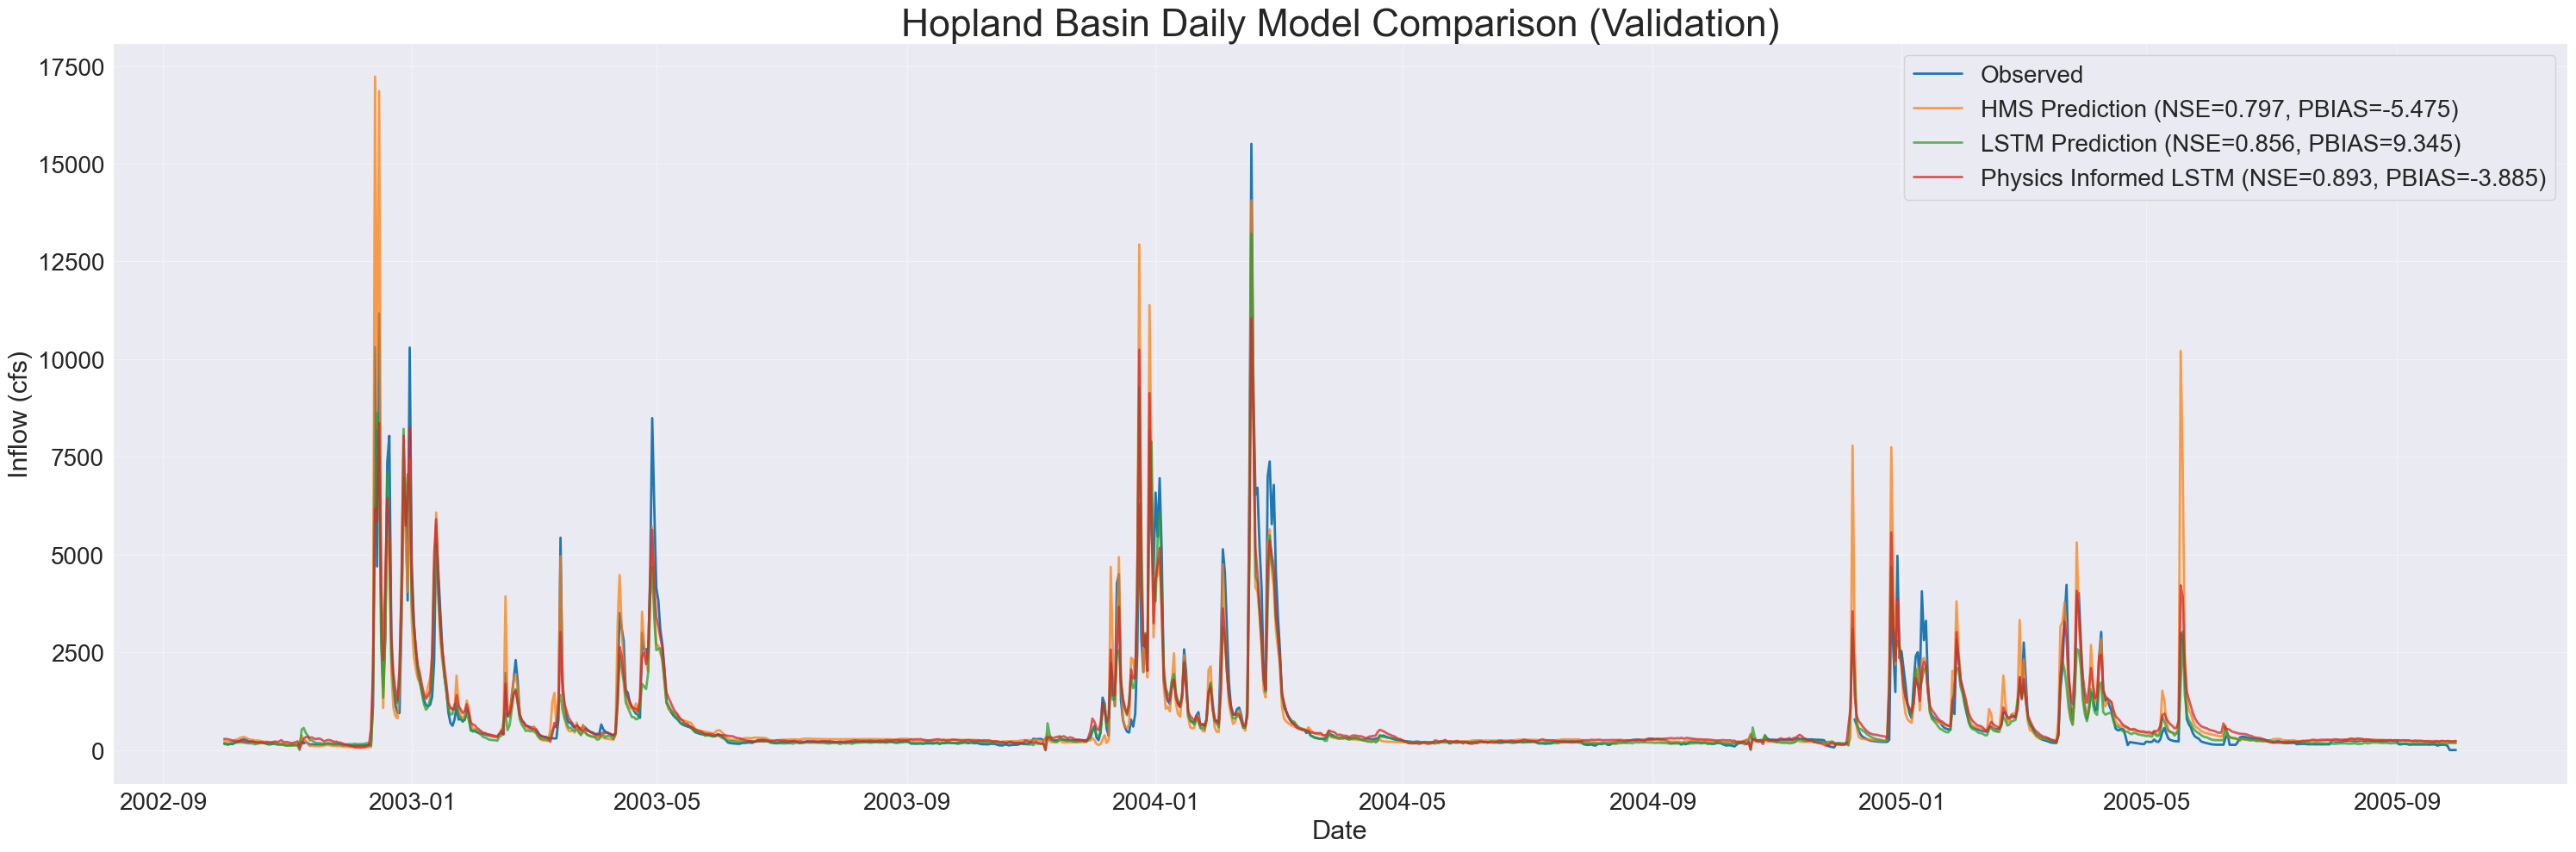

In [19]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Hopland Basin Daily Model Comparison (Validation)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="hopland_daily_val_metrics.csv", ts_out="hopland_daily_val_combined_ts.csv", fig_out="hopland_daily_val_model_comparison.png", legend_font=20, axis_font=22)
else:
    combined_df_val = read_csv_artifact("hopland_daily_val_combined_ts.csv", kind="csv", period="validation", stamp = READ_STAMP, run_label = RUN_LABEL)
    plot_timeseries_comparison(source=combined_df_val, title="Hopland Basin Daily Model Comparison (Validation)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="hopland_daily_val_metrics.csv", ts_out="hopland_daily_val_combined_ts.csv", fig_out="hopland_daily_val_model_comparison.png", legend_font=20, axis_font=22)

In [20]:
if skip_best_model_validation:
    val_metrics = read_csv_artifact("hopland_daily_val_metrics.csv", kind="metrics", period="validation", index_col=0, stamp = READ_STAMP, run_label = RUN_LABEL)
    print(val_metrics)

                       HMS           LSTM         PILSTM
NSE               0.797364       0.855922       0.892797
MSE          389523.715276  276958.372722  206074.616828
RMSE            624.118350     526.268347     453.954422
KGE               0.875391       0.801570       0.848625
Alpha-NSE         1.062044       0.839075       0.862859
Beta-KGE          1.054750       0.906550       1.038852
Beta-NSE          0.029795      -0.050856       0.021143
Pearson-r         0.906831       0.931118       0.949037
FHV               6.805005     -14.368060     -14.959267
FMS              -5.549918       4.240018      -0.680640
FLV              94.254225      -0.700391      -2.244331
Peak-Timing       0.000000       0.200000       0.000000
Peak-MAPE        24.485547      35.976783      25.844630
PBIAS            -5.475018       9.345005      -3.885215


# Re-run testing with the best hyperparameters

In [21]:
if not skip_best_model_test:
    hoplandNoPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,  
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=True, 
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    hoplandNoPhysicsExtBest.train()
    no_physics_test_csv, no_physics_test_metrics = hoplandNoPhysicsExtBest.results('test')
    no_physics_test_metrics

In [22]:
if not skip_best_model_test:
    hoplandPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,  
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=True,
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    hoplandPhysicsExtBest.train()
    physics_test_csv, physics_test_metrics = hoplandPhysicsExtBest.results('test')
    physics_test_metrics

HMS
  NSE = 0.796
  PBIAS = -18.532
LSTM
  NSE = 0.807
  PBIAS = -17.191
PILSTM
  NSE = 0.792
  PBIAS = -17.197


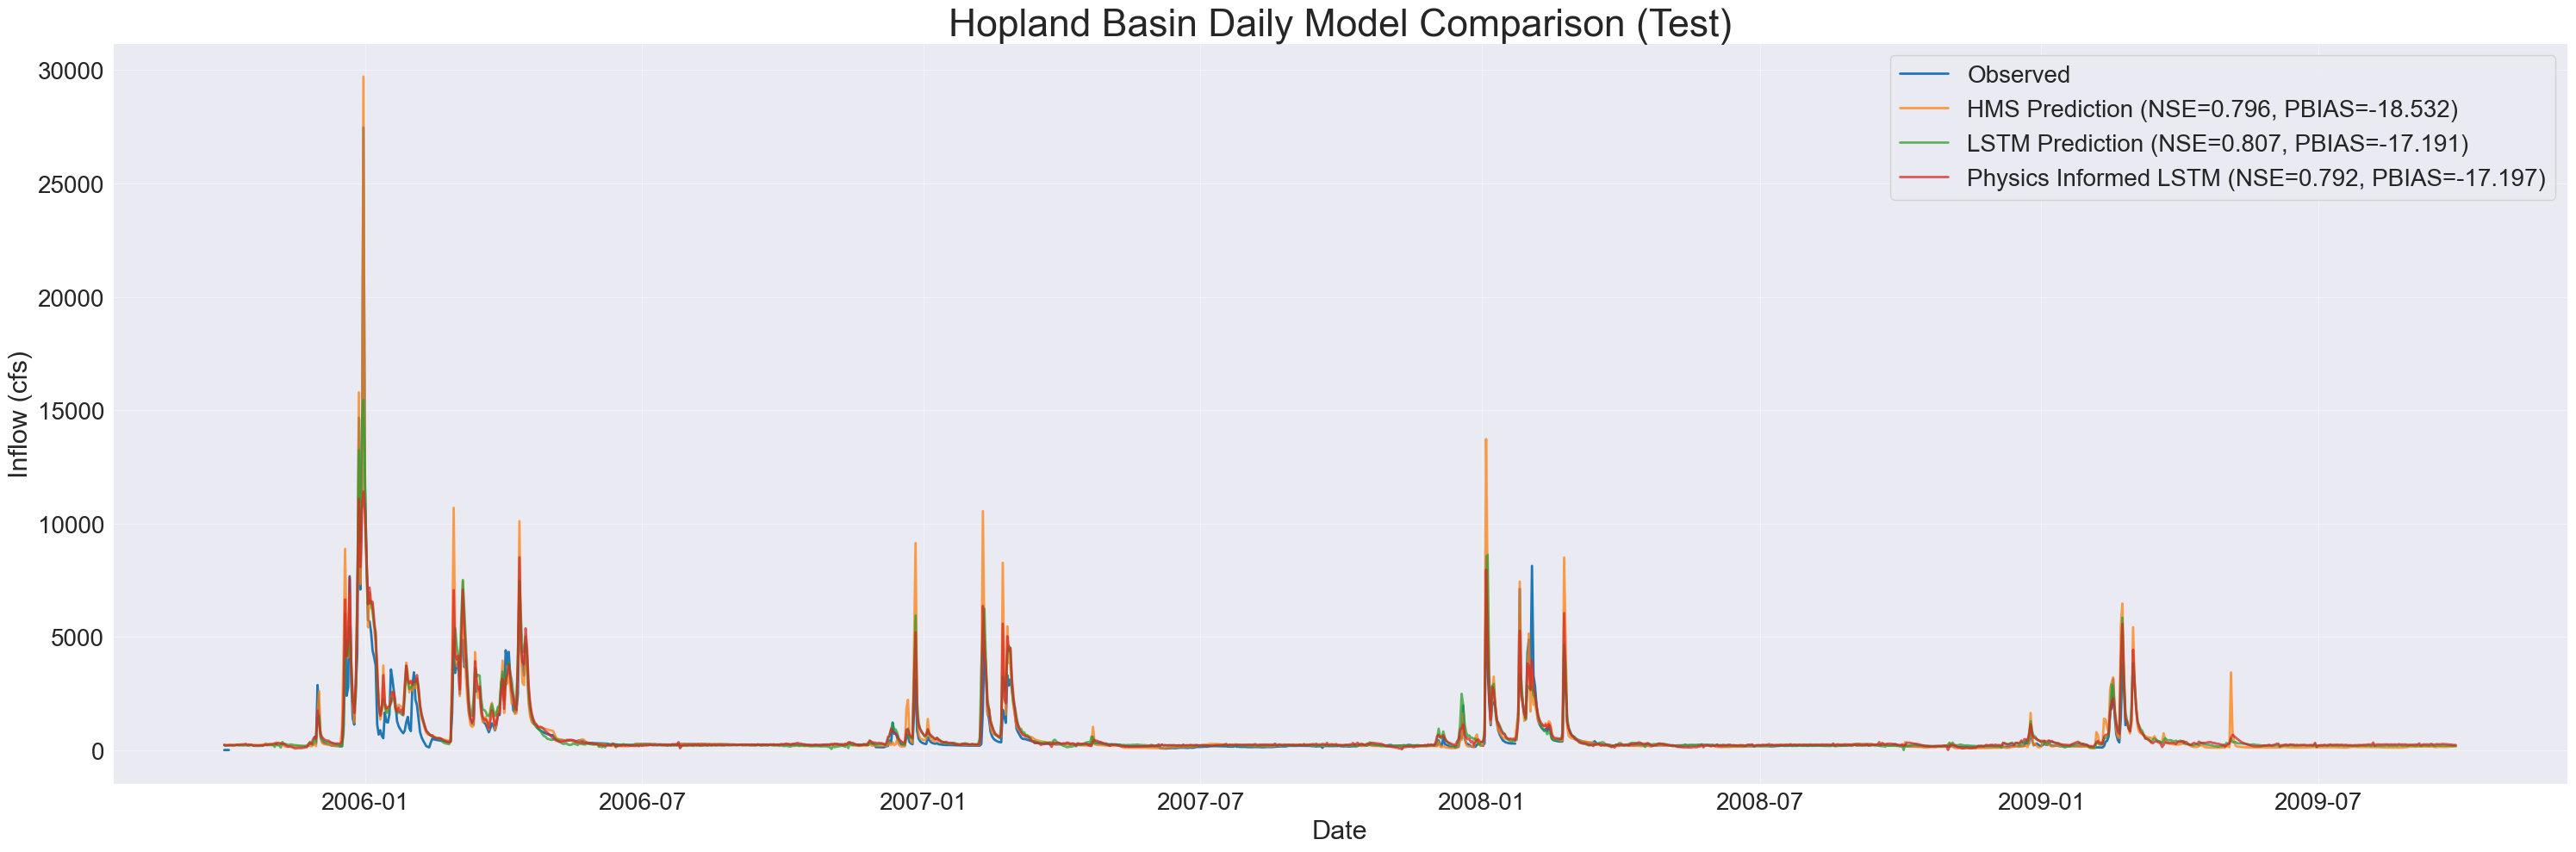

In [23]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Hopland Basin Daily Model Comparison (Test)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="hopland_daily_test_metrics.csv", ts_out="hopland_daily_test_combined_ts.csv", fig_out="hopland_daily_test_model_comparison.png", legend_font=20, axis_font=22)
else:
    combined_df = read_csv_artifact("hopland_daily_test_combined_ts.csv", kind="csv", period="test", stamp = READ_STAMP, run_label = RUN_LABEL)
    plot_timeseries_comparison(source=combined_df, title="Hopland Basin Daily Model Comparison (Test)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="hopland_daily_test_metrics.csv", ts_out="hopland_daily_test_combined_ts.csv", fig_out="hopland_daily_test_model_comparison.png", legend_font=20, axis_font=22)

In [24]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Hopland Basin Daily Model Comparison (Test)", backend="plotly", metrics=["NSE", "PBIAS"], metrics_out="hopland_daily_test_metrics.csv", ts_out="hopland_daily_test_combined_ts.csv", fig_out="hopland_daily_model_test_comparison.png", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Hopland Basin Daily Model Comparison (Test)", backend="plotly", metrics=["NSE", "PBIAS"], metrics_out="hopland_daily_test_metrics.csv", ts_out="hopland_daily_test_combined_ts.csv", fig_out="hopland_daily_test_model_comparison.png", legend_font=12, axis_font=22)

HMS
  NSE = 0.796
  PBIAS = -18.532
LSTM
  NSE = 0.807
  PBIAS = -17.191
PILSTM
  NSE = 0.792
  PBIAS = -17.197


In [25]:
test_metrics = read_csv_artifact("hopland_daily_test_metrics.csv", kind="metrics", period="test", index_col=0, stamp = READ_STAMP, run_label = RUN_LABEL)
print(test_metrics)

                       HMS           LSTM         PILSTM
NSE               0.795537       0.806887       0.791718
MSE          404943.195996  382463.120987  412505.890947
RMSE            636.351472     618.436028     642.266215
KGE               0.728365       0.802258       0.783448
Alpha-NSE         1.186275       0.979580       0.922889
Beta-KGE          1.185323       1.171912       1.171974
Beta-NSE          0.079849       0.074071       0.074097
Pearson-r         0.931134       0.904444       0.893354
FHV              23.945896       1.263210      -2.858127
FMS              32.032020      30.587323      26.316698
FLV              96.362785      -1.790633      -1.939248
Peak-Timing       0.250000       0.250000       0.250000
Peak-MAPE        36.378146      34.070457      27.604746
PBIAS           -18.532311     -17.191232     -17.197416


In [26]:
if not skip_best_model_test:
    write_paths("no_physics", hoplandNoPhysicsExtBest, filename = RUNS_FILE)
    write_paths("physics", hoplandPhysicsExtBest, filename = RUNS_FILE)
    archived_path = archive_runs_json(Path(RUNS_FILE), BASIN, MODE, RUN_LABEL, RUN_STAMP)

In [27]:
end_time = datetime.utcnow()
print("\nEnd time:", end_time.strftime("%Y-%m-%d %H:%M:%S"))
print("Total time:", end_time - start_time)


End time: 2025-08-26 14:20:15
Total time: 0:00:10.529510


##### Additional Plots

In [28]:
if skip_best_model_validation:
    combined_df_val = read_csv_artifact("hopland_daily_val_combined_ts.csv", kind="csv", period="validation", stamp = READ_STAMP, run_label = RUN_LABEL)
if skip_best_model_test:
    combined_df = read_csv_artifact("hopland_daily_test_combined_ts.csv", kind="csv", period="test", stamp = READ_STAMP, run_label = RUN_LABEL)

In [29]:
metric_list = ["NSE", "PBIAS"]

wettest_start_val = "2003-10-01"
wettest_end_val = "2004-09-30"
dryest_start_val = "2004-10-01"
dryest_end_val = "2005-09-30"
wettest_start_test = "2005-10-01"
wettest_end_test = "2006-09-30"
dryest_start_test = "2008-10-01"
dryest_end_test = "2009-09-30"

HMS
  NSE = 0.797
  PBIAS = -5.475
LSTM
  NSE = 0.856
  PBIAS = 9.345
PILSTM
  NSE = 0.893
  PBIAS = -3.885


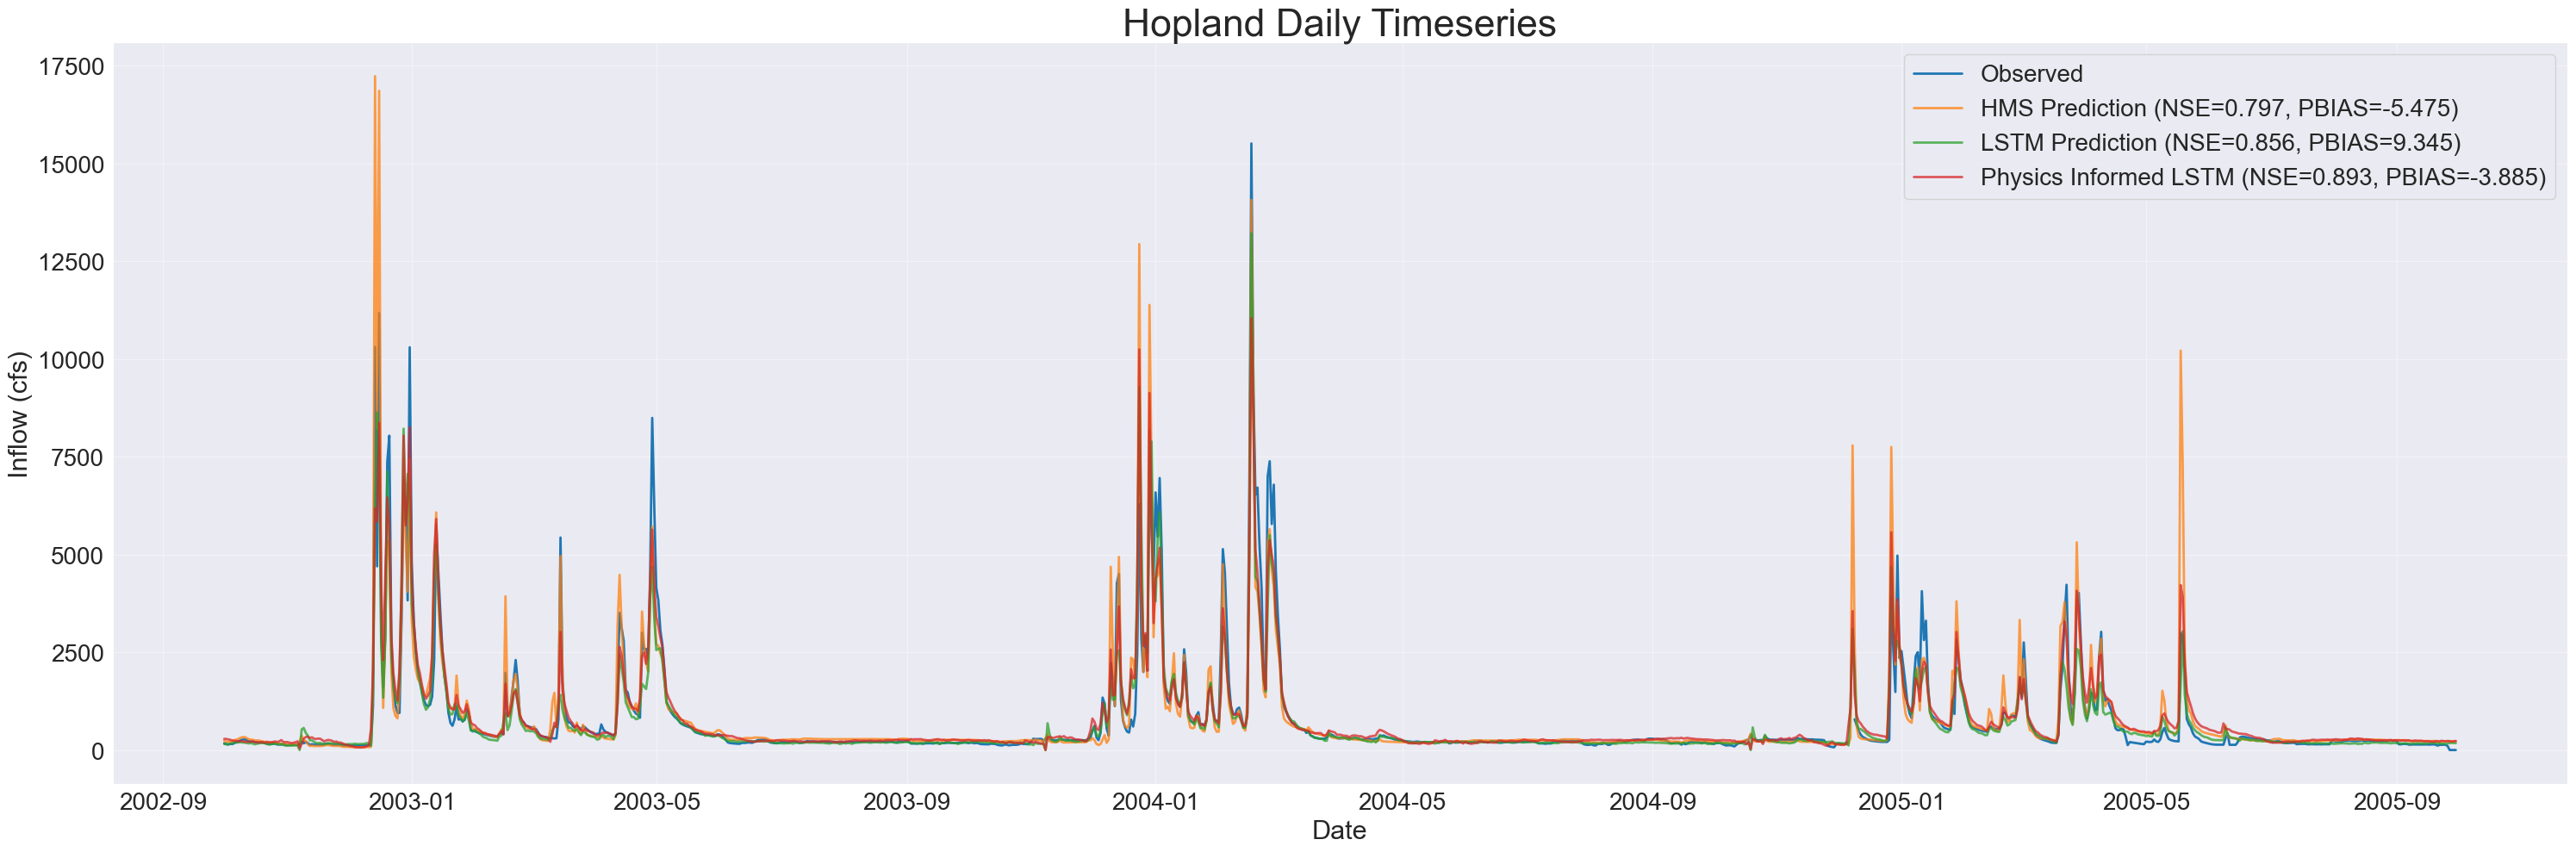

In [30]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Hopland Daily Timeseries", backend="mpl", metrics=metric_list, metrics_out="hopland_daily_val_metrics.csv", ts_out="hopland_daily_val_combined_ts.csv", fig_out="hopland_daily_val_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df_val, title="Hopland Daily Timeseries", backend="mpl", metrics=metric_list, metrics_out="hopland_daily_val_metrics.csv", ts_out="hopland_daily_val_combined_ts.csv", fig_out="hopland_daily_val_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = 0.796
  PBIAS = -18.532
LSTM
  NSE = 0.807
  PBIAS = -17.191
PILSTM
  NSE = 0.792
  PBIAS = -17.197


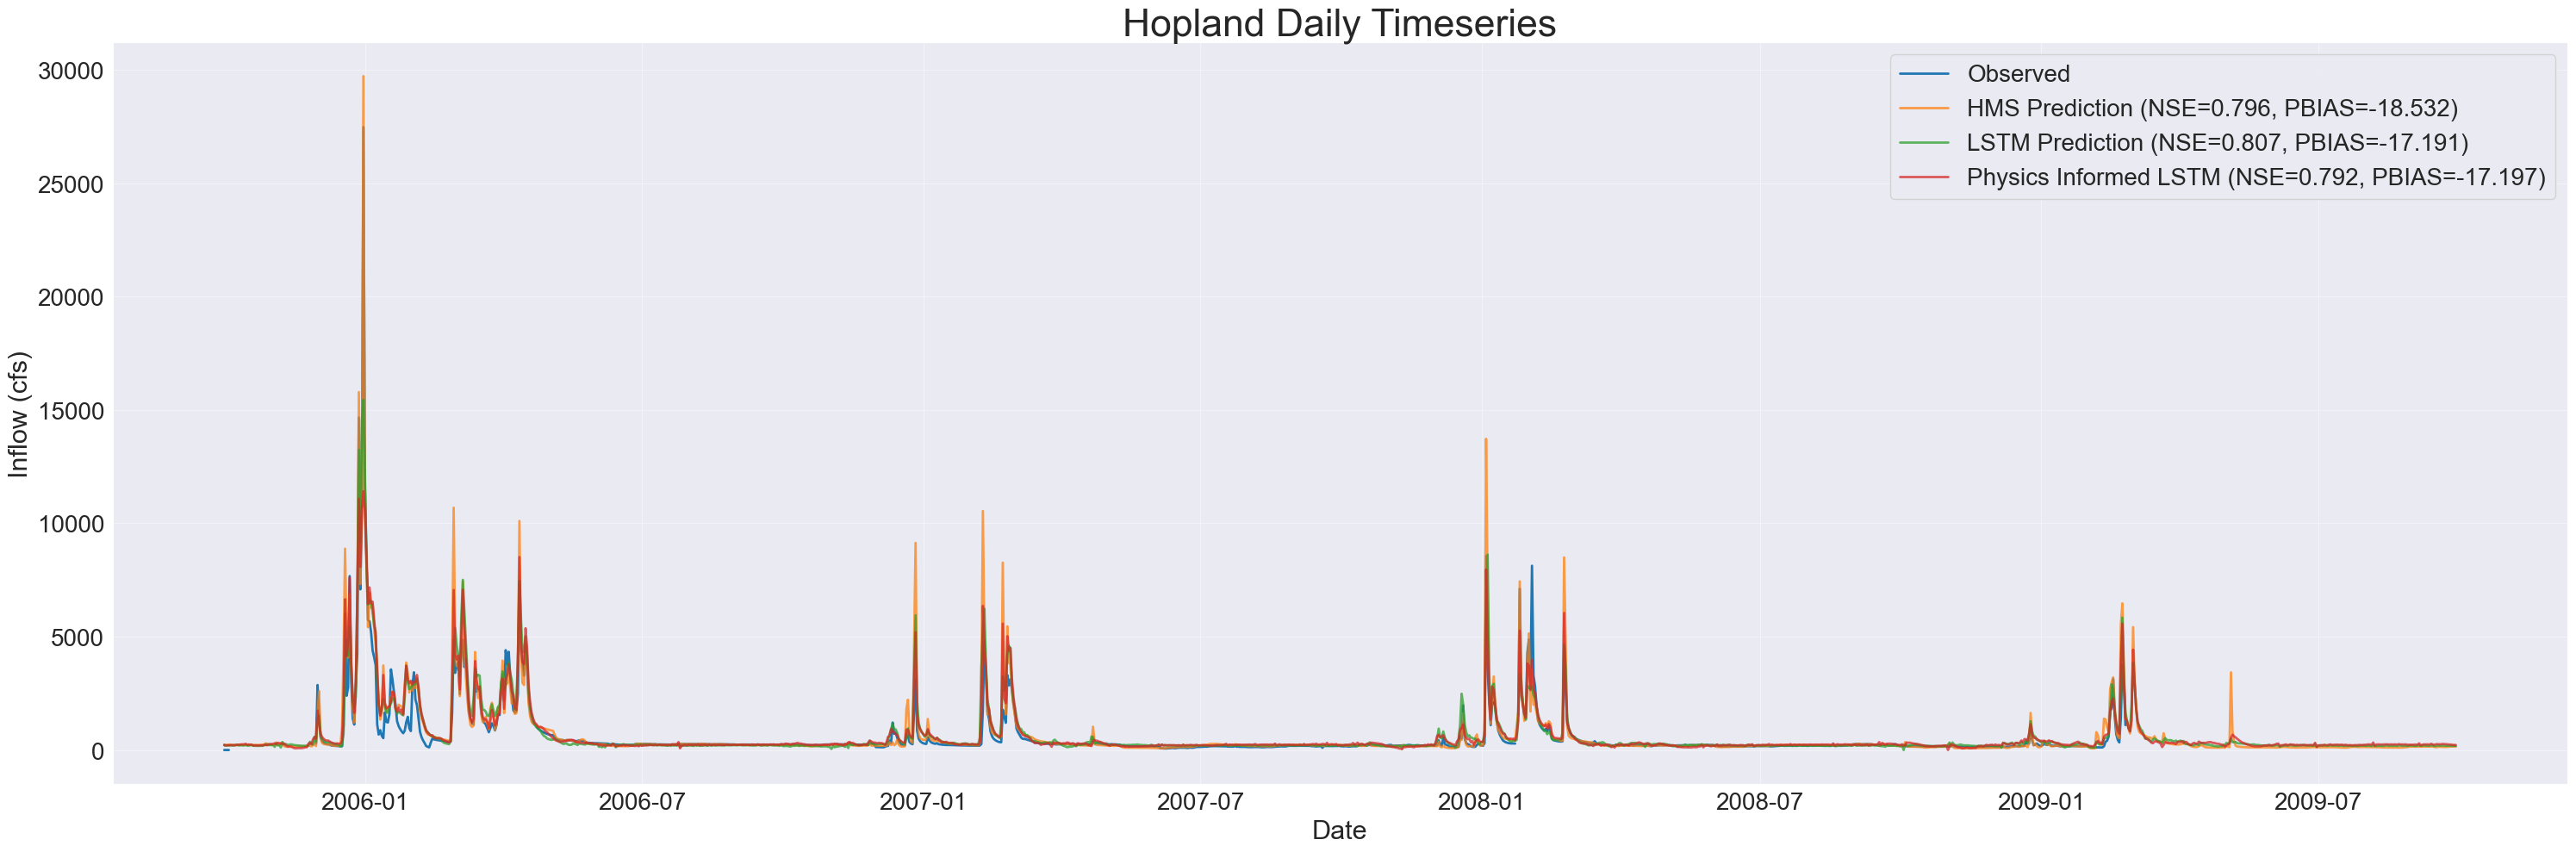

In [31]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Hopland Daily Timeseries", backend="mpl", metrics=metric_list, metrics_out="hopland_daily_test_metrics.csv", ts_out="hopland_daily_test_combined_ts.csv", fig_out="hopland_daily_test_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Hopland Daily Timeseries", backend="mpl", metrics=metric_list, metrics_out="hopland_daily_test_metrics.csv", ts_out="hopland_daily_test_combined_ts.csv", fig_out="hopland_daily_test_model_comparison.png", legend_font=20, axis_font=22)

In [32]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Hopland Daily Timeseries", backend="plotly", metrics=metric_list, metrics_out="hopland_daily_test_metrics.csv", ts_out="hopland_daily_test_combined_ts.csv", fig_out="hopland_daily_test_model_comparison.png", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Hopland Daily Timeseries", backend="plotly", metrics=metric_list, metrics_out="hopland_daily_test_metrics.csv", ts_out="hopland_daily_test_combined_ts.csv", fig_out="hopland_daily_test_model_comparison.png", legend_font=12, axis_font=22)

HMS
  NSE = 0.796
  PBIAS = -18.532
LSTM
  NSE = 0.807
  PBIAS = -17.191
PILSTM
  NSE = 0.792
  PBIAS = -17.197


##### Wettest Year Performance

HMS
  NSE = 0.864
  PBIAS = 5.061
LSTM
  NSE = 0.892
  PBIAS = 8.781
PILSTM
  NSE = 0.898
  PBIAS = 3.496


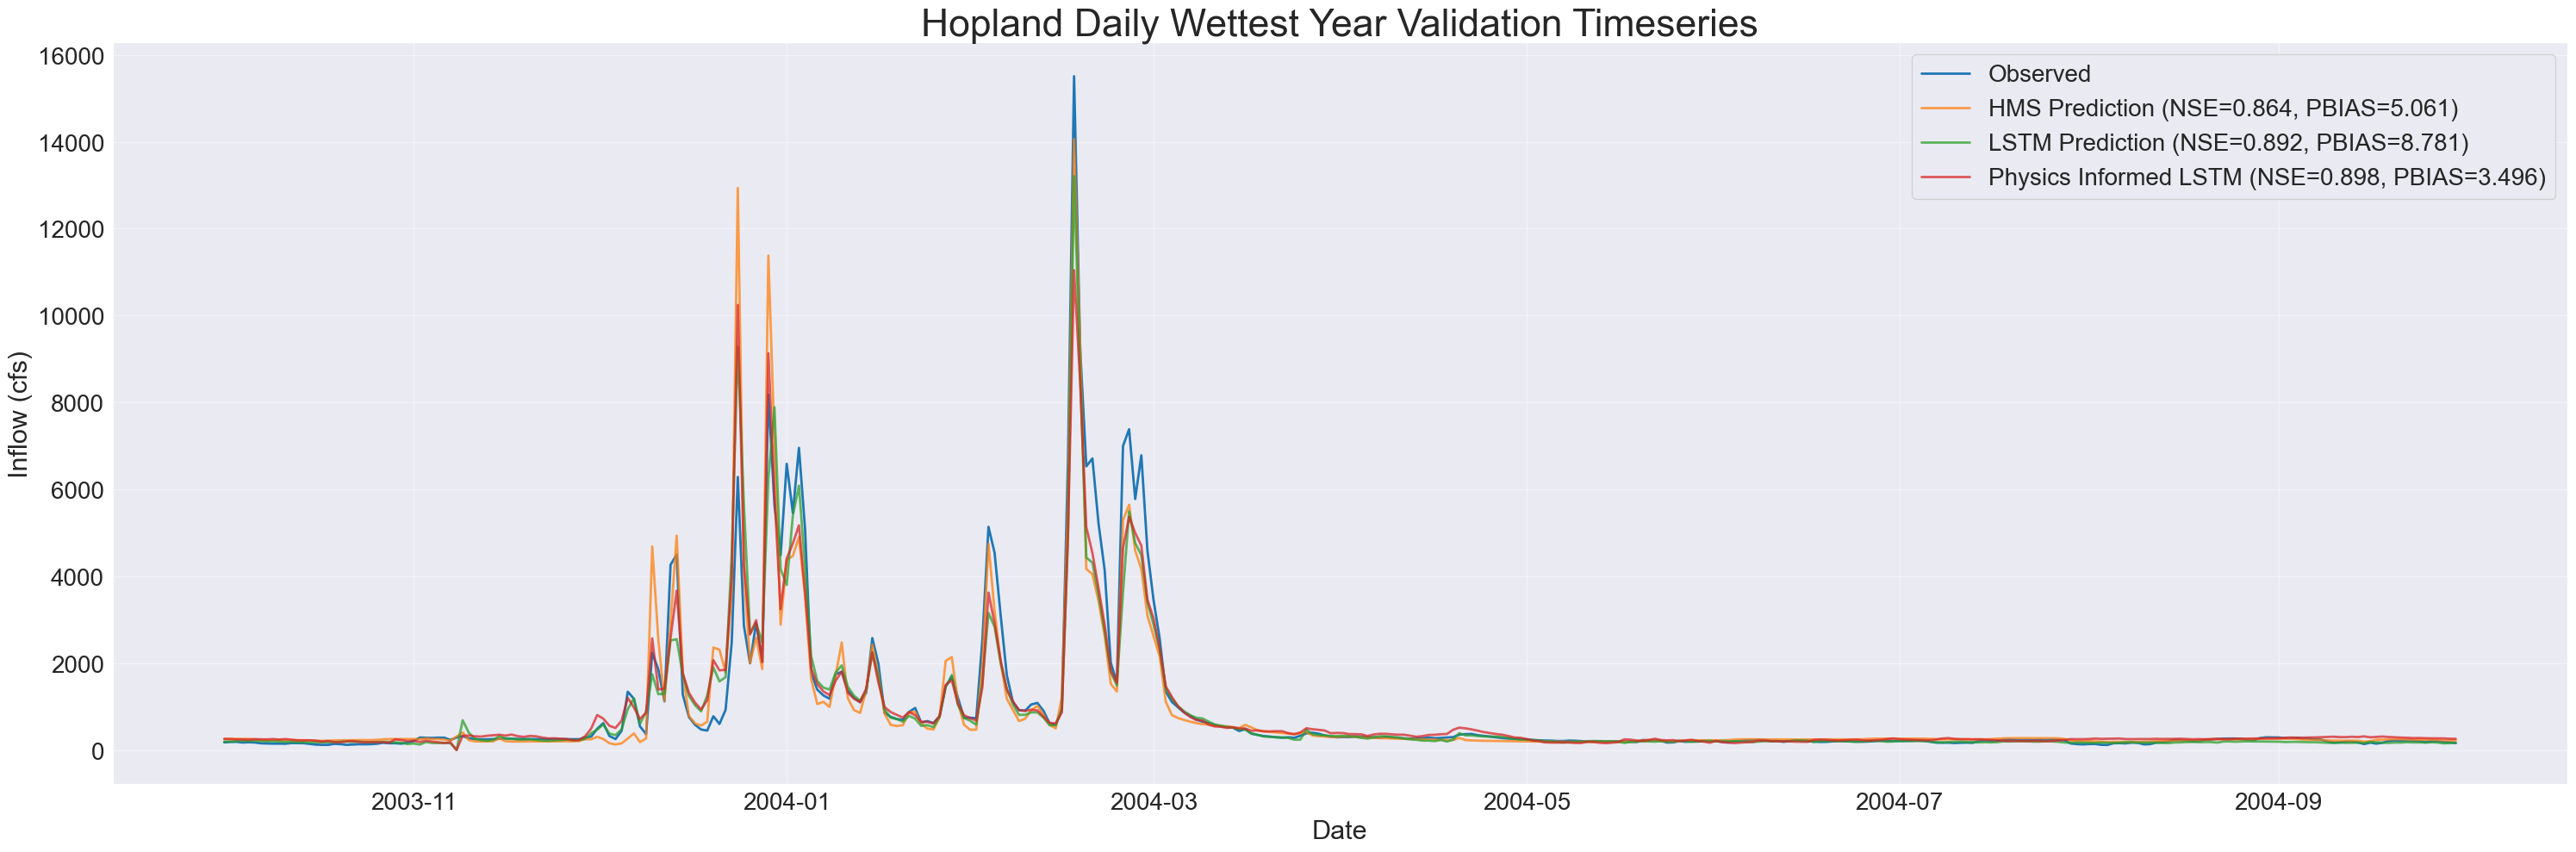

In [33]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Hopland Daily Wettest Year Validation Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_val, end_date=wettest_end_val, metrics_out="hopland_daily_val_wet_metrics.csv", ts_out="hopland_daily_val_wet_combined_ts.csv", fig_out="hopland_daily_val_wet_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df_val, title="Hopland Daily Wettest Year Validation Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_val, end_date=wettest_end_val, metrics_out="hopland_daily_val_wet_metrics.csv", ts_out="hopland_daily_val_wet_combined_ts.csv", fig_out="hopland_daily_val_wet_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = 0.898
  PBIAS = -16.645
LSTM
  NSE = 0.834
  PBIAS = -13.261
PILSTM
  NSE = 0.777
  PBIAS = -11.893


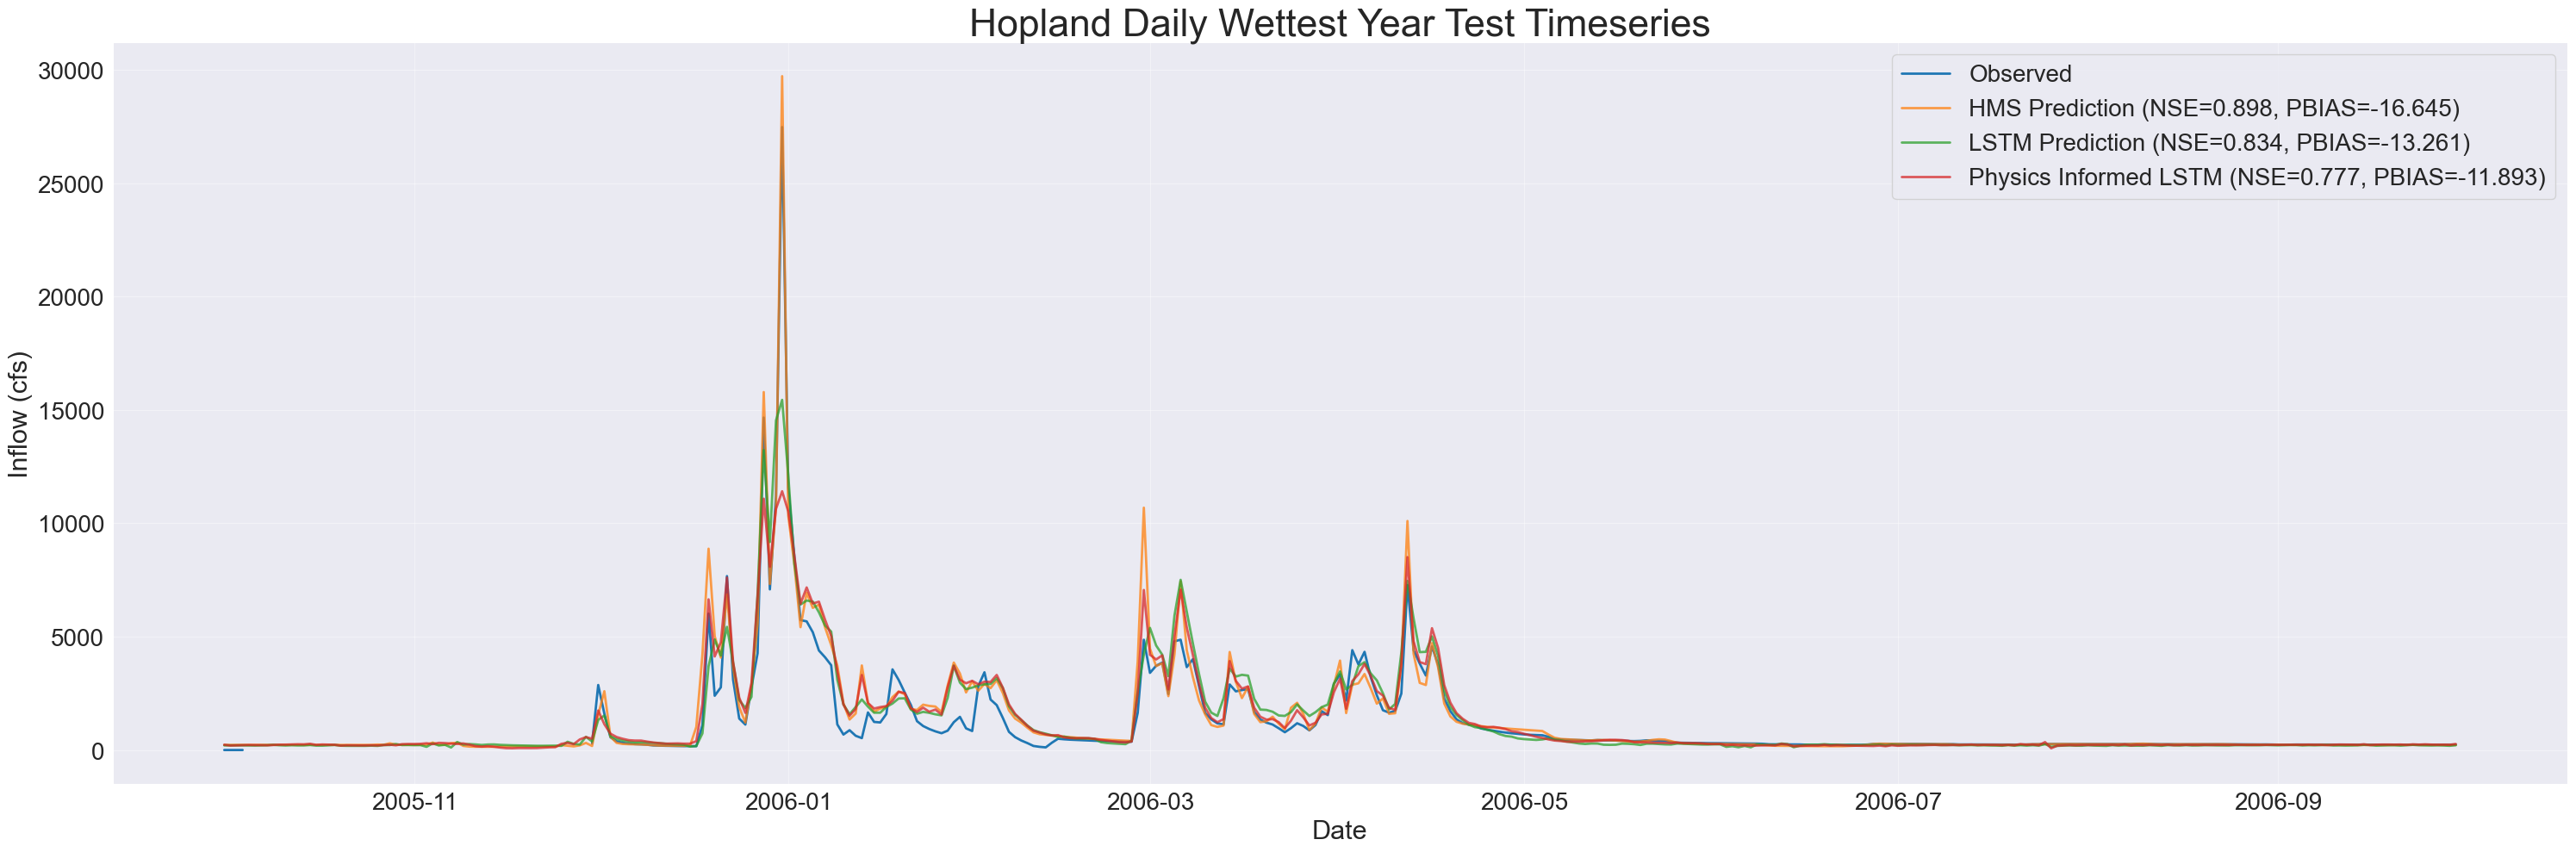

In [34]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Hopland Daily Wettest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="hopland_daily_test_wet_metrics.csv", ts_out="hopland_daily_test_wet_combined_ts.csv", fig_out="hopland_daily_test_wet_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Hopland Daily Wettest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="hopland_daily_test_wet_metrics.csv", ts_out="hopland_daily_test_wet_combined_ts.csv", fig_out="hopland_daily_test_wet_model_comparison.png", legend_font=20, axis_font=22)

In [35]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Hopland Daily Wettest Year Test Timeseries", backend="plotly", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="hopland_daily_test_wet_metrics.csv", ts_out="hopland_daily_test_wet_combined_ts.csv", fig_out="hopland_daily_test_wet_model_comparison.png", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Hopland Daily Wettest Year Test Timeseries", backend="plotly", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="hopland_daily_test_wet_metrics.csv", ts_out="hopland_daily_test_wet_combined_ts.csv", fig_out="hopland_daily_test_wet_model_comparison.png", legend_font=12, axis_font=22)

HMS
  NSE = 0.898
  PBIAS = -16.645
LSTM
  NSE = 0.834
  PBIAS = -13.261
PILSTM
  NSE = 0.777
  PBIAS = -11.893


##### Driest Year Performance

HMS
  NSE = 0.418
  PBIAS = -20.927
LSTM
  NSE = 0.803
  PBIAS = 6.809
PILSTM
  NSE = 0.848
  PBIAS = -17.476


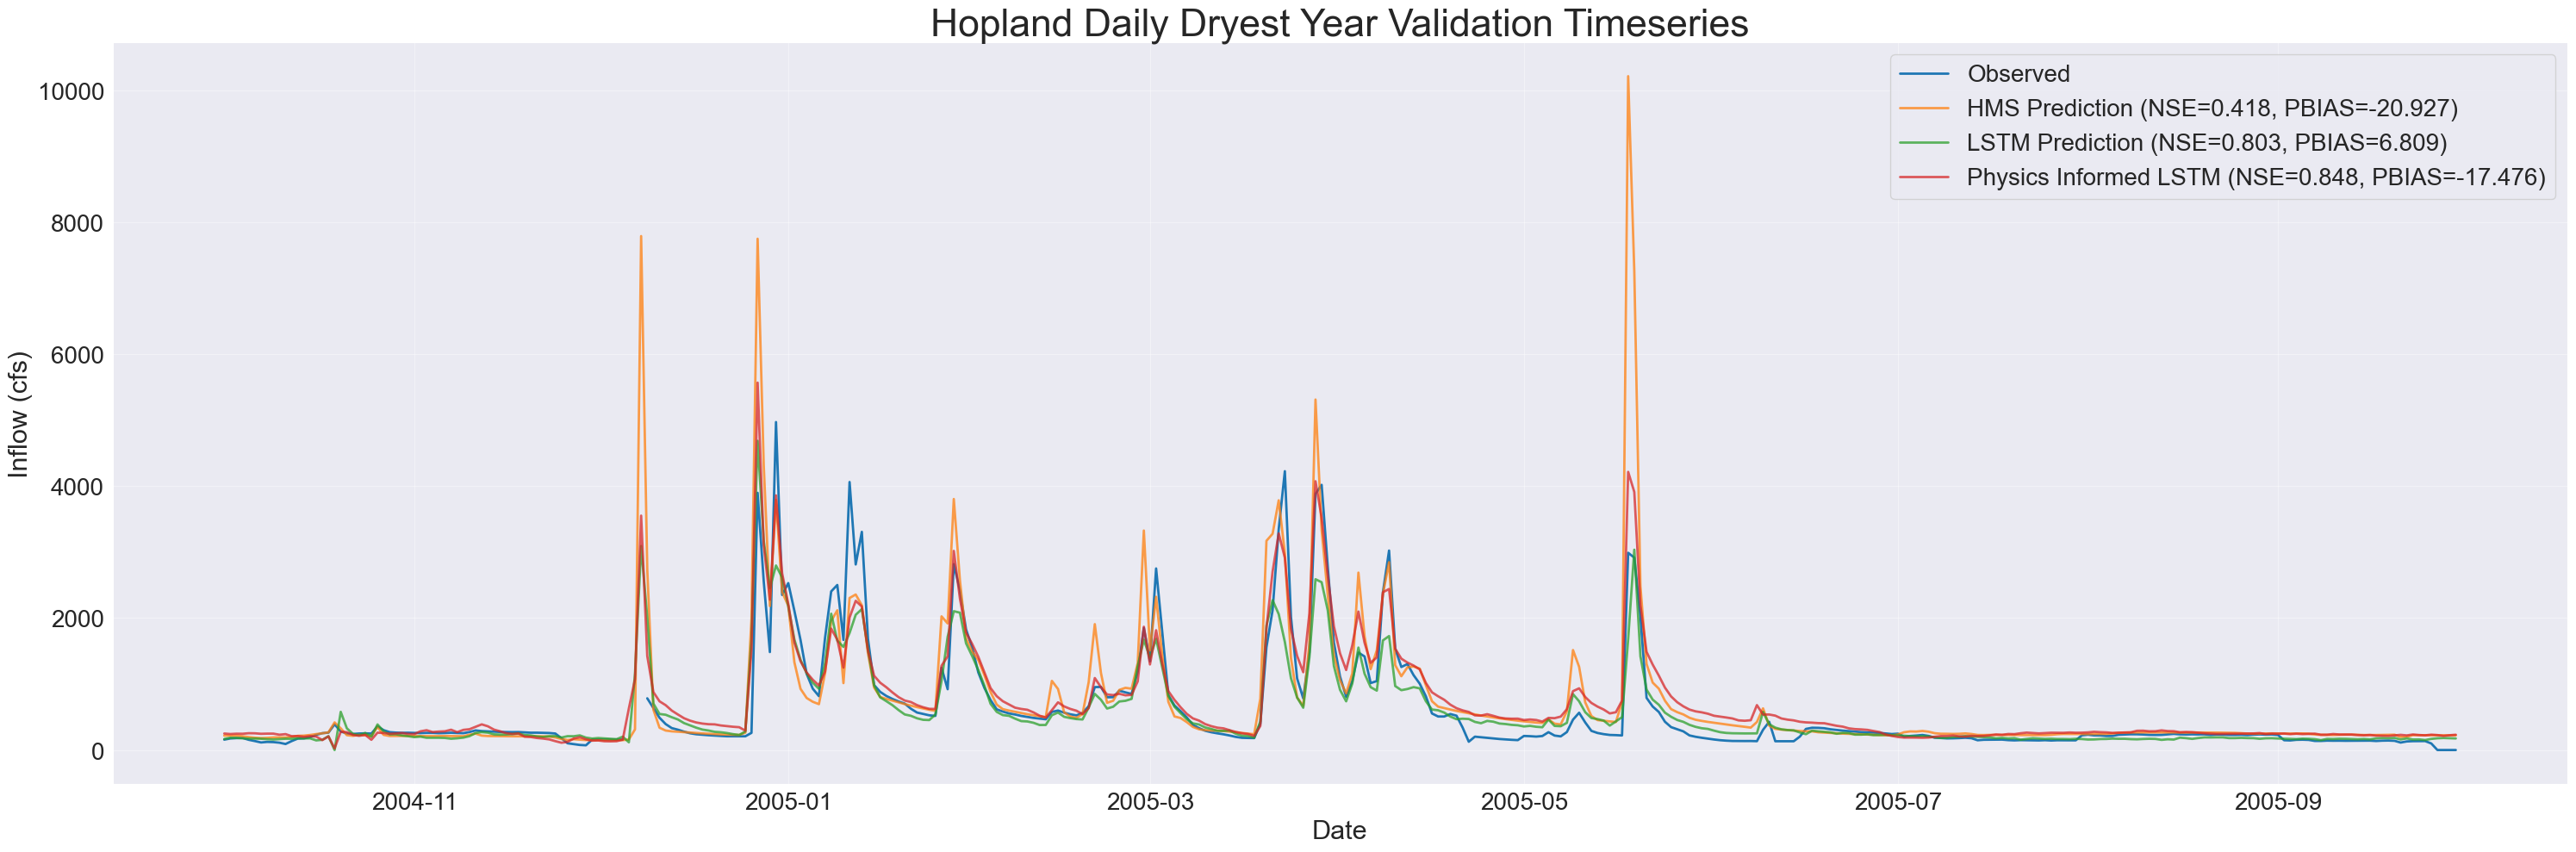

In [36]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Hopland Daily Dryest Year Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_val, end_date=dryest_end_val, metrics_out="hopland_daily_val_dry_metrics.csv", ts_out="hopland_daily_val_dry_combined_ts.csv", fig_out="hopland_daily_val_dry_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df_val, title="Hopland Daily Dryest Year Validation Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_val, end_date=dryest_end_val, metrics_out="hopland_daily_val_dry_metrics.csv", ts_out="hopland_daily_val_dry_combined_ts.csv", fig_out="hopland_daily_val_dry_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = 0.167
  PBIAS = -31.710
LSTM
  NSE = 0.720
  PBIAS = -41.252
PILSTM
  NSE = 0.648
  PBIAS = -42.942


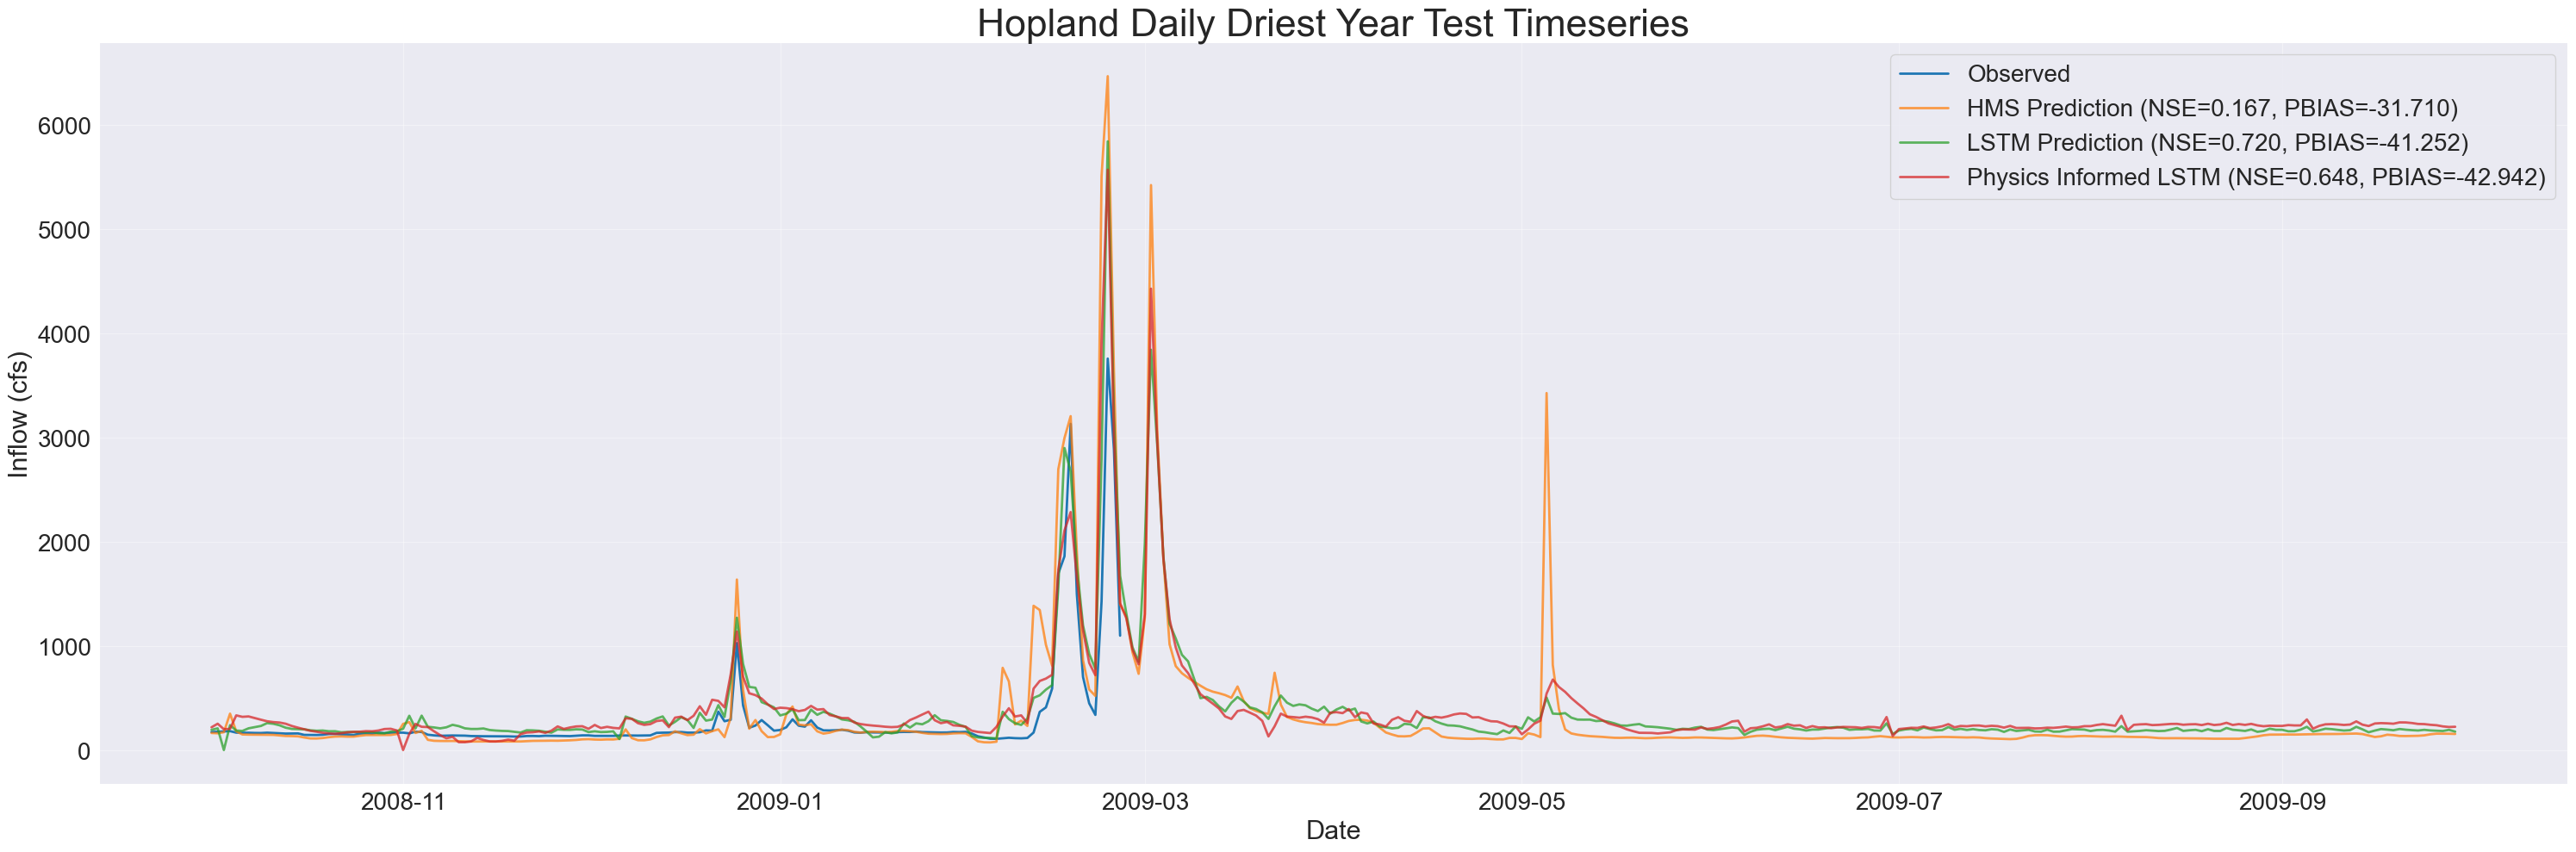

In [37]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Hopland Daily Driest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="hopland_daily_test_dry_metrics.csv", ts_out="hopland_daily_test_dry_ts.csv", fig_out="hopland_daily_test_dry_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Hopland Daily Driest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="hopland_daily_test_dry_metrics.csv", ts_out="hopland_daily_test_dry_ts.csv", fig_out="hopland_daily_test_dry_model_comparison.png", legend_font=20, axis_font=22)

In [38]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Hopland Daily Driest Year Test Timeseries", backend="plotly", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="hopland_daily_test_dry_metrics.csv", ts_out="hopland_daily_test_dry_ts.csv", fig_out="hopland_daily_test_dry_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Hopland Daily Driest Year Test Timeseries", backend="plotly", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="hopland_daily_test_dry_metrics.csv", ts_out="hopland_daily_test_dry_ts.csv", fig_out="hopland_daily_test_dry_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = 0.167
  PBIAS = -31.710
LSTM
  NSE = 0.720
  PBIAS = -41.252
PILSTM
  NSE = 0.648
  PBIAS = -42.942


##### Gridded Timeseries Plots - Validation and Testing

In [39]:
if not skip_best_model_validation:
    ts_triptych_v3((no_physics_val_csv, physics_val_csv, path_to_physics_data),wet_start=wettest_start_val, wet_end=wettest_end_val, dry_start=dryest_start_val, dry_end=dryest_end_val, save_path="hopland_daily_TS_validation.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d-%b-%Y", figsize=(10, 10), dpi=600, hspace=0.2, main_title="Hopland Daily Validation Period Timeseries Across Models", main_title_font=14, main_title_y=0.99, main_title_pad=0.05, row_titles=("Full Validation period","Most-wet water-year","Most-dry water-year"))
else:
    ts_triptych_v3(combined_df_val, wet_start=wettest_start_val, wet_end=wettest_end_val, dry_start=dryest_start_val, dry_end=dryest_end_val, save_path="hopland_daily_TS_validation.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d‑%b‑%Y", figsize=(10, 10), dpi=600, hspace=0.2,main_title = "Hopland Daily Validation Timeseries Across Models", main_title_font=14, main_title_y = 0.99, main_title_pad = 0.05, row_titles=("Full validation period", "Most‑wet water‑year", "Most‑dry water‑year"))

/Users/canruso/Desktop/UCB-USACE-LSTMs/notebooks/basins/hopland/../../../../UCB-USACE-LSTMs/UCB_training/UCB_plotting.py:363: UserWarning:

Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.



In [40]:
if not skip_best_model_test:
    ts_triptych_v3((no_physics_test_csv, physics_test_csv, path_to_physics_data), wet_start=wettest_start_test, wet_end=wettest_end_test, dry_start=dryest_start_test, dry_end=dryest_end_test, save_path="hopland_daily_TS_testing.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d-%b-%Y", figsize=(10, 10), dpi=600, hspace=0.2, main_title="Hopland Daily Test Period Timeseries Across Models", main_title_font=14, main_title_y=0.99, main_title_pad=0.05, row_titles=("Full Testing period","Most-wet water-year","Most-dry water-year"))
    
else:
    ts_triptych_v3(combined_df, wet_start=wettest_start_test, wet_end=wettest_end_test, dry_start=dryest_start_test, dry_end=dryest_end_test, save_path="hopland_daily_TS_testing.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d‑%b‑%Y", figsize=(10, 10), dpi=600, hspace=0.2, main_title = "Hopland Daily Test Period Timeseries Across Models", main_title_font=14, main_title_y = 0.99, main_title_pad = 0.05, row_titles=("Full Testing period", "Most‑wet water‑year", "Most‑dry water‑year"))

/Users/canruso/Desktop/UCB-USACE-LSTMs/notebooks/basins/hopland/../../../../UCB-USACE-LSTMs/UCB_training/UCB_plotting.py:363: UserWarning:

Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.



##### Gridded Scatter Plots - Testing

In [41]:
if not skip_best_model_test:
    scatter_pngs = scatter_triptych_pngs_v3((no_physics_test_csv, physics_test_csv, path_to_physics_data), wet_start = wettest_start_test, wet_end = wettest_end_test, dry_start = dryest_start_test,  dry_end = dryest_end_test, out_dir = "hopland_daily_scatter", layout = "horizontal", square_side  = 4.5, legend_font  = 16, axis_font = 16, point_size = 28, top_pad = .90, suptitle_y = 1.04, dpi = 600, row_titles = ("Hopland Daily – Full test period", "Hopland Daily – Wettest water‑year", "Hopland Daily – Driest water‑year"), resolution = "daily")
else:
    scatter_pngs = scatter_triptych_pngs_v3(combined_df, wet_start = wettest_start_test, wet_end = wettest_end_test, dry_start = dryest_start_test,  dry_end = dryest_end_test, out_dir = "hopland_daily_scatter", layout = "horizontal", square_side  = 4.5, legend_font  = 16, axis_font = 16, point_size = 28, top_pad = .90, suptitle_y = 1.04, dpi = 600, row_titles = ("Hopland Daily – Full test period", "Hopland Daily – Wettest water‑year", "Hopland Daily – Driest water‑year"), resolution = "daily")